In [21]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
os.chdir('/Users/andreavelazquez/Desktop/School stuff/Spring 25/QBIO465/Final_project/')

# Data pre-processing and cleaning

## Import data and cleanup

In [3]:
#Import data and transpose so we have pts as rows, genes as cols
data_raw = pd.read_csv('TCGA_OV_rna_counts.csv', index_col=0)
data_raw = data_raw.T  

#Remove genes with all 0s
has_nonzero = (data_raw != 0).any(axis=0) 
data = data_raw.loc[:, has_nonzero] 

## Identify important genes with sparce counts

Non-sparse genes saved for later


/opt/anaconda3/envs/andreav/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/andreav/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


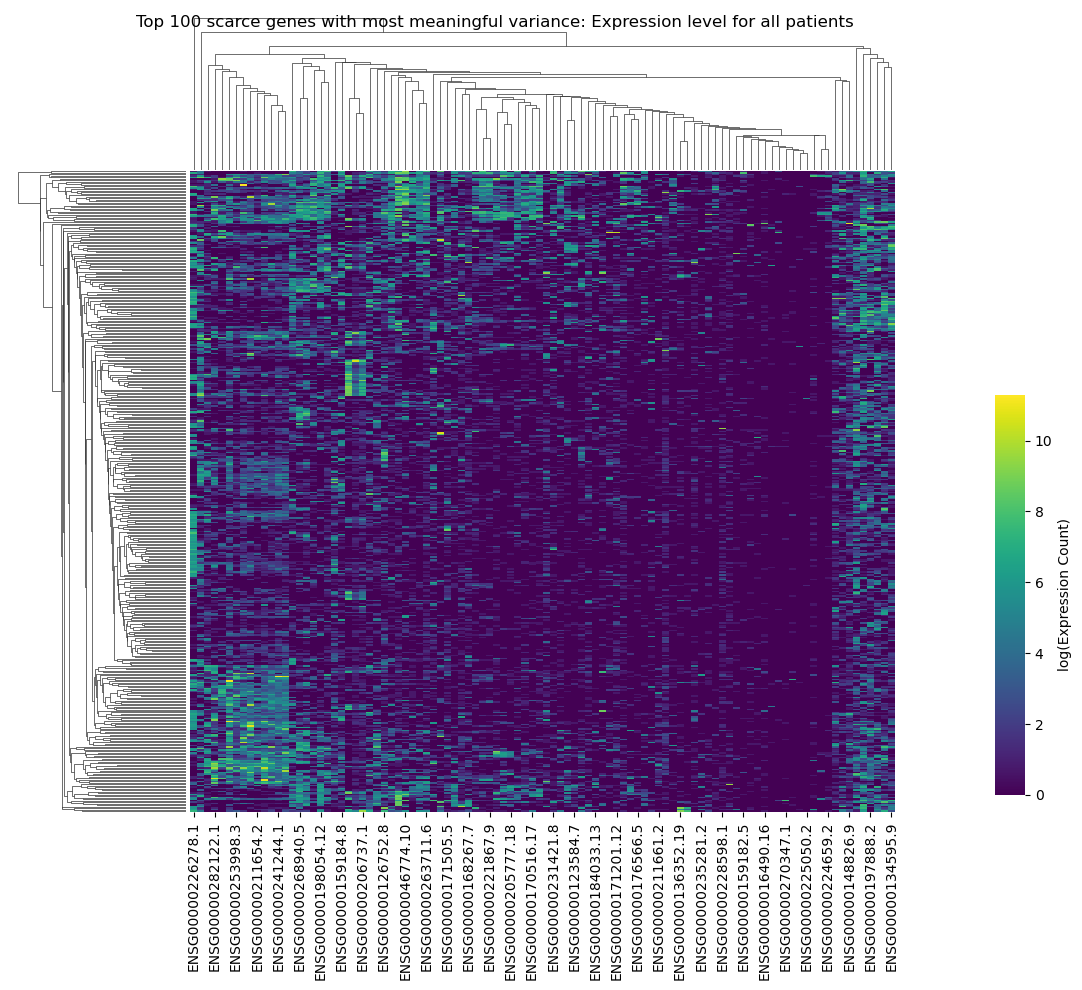

In [9]:
#Identify sparse genes (among remaining genes)-- still have a lot of zeros across patients
zeros_per_gene = (data == 0).sum(axis=0) 
print('Non-sparse genes saved for later')
sparse_genes = zeros_per_gene[zeros_per_gene > 100].index #Define the genes with the most zeros as 

#Subset sparse genes and score them based on which have the highest mean 
data_sparse = data[sparse_genes]
nonzero_mean = data_sparse.replace(0, np.nan).mean(axis=0)
score_df = pd.DataFrame({
    'n_zeros': zeros_per_gene.loc[sparse_genes],
    'nonzero_mean': nonzero_mean
})
score_df['score'] = score_df['n_zeros'] * score_df['nonzero_mean']
top_sparse_genes = score_df.sort_values('score', ascending=False).head(100).index

#sparse_top_var= data[top_sparce_genes]
#sparse_topvar.to_csv('TCGA_OV_rnaCounts_sparse_topvar.csv', index=True)


#Subset the logged data for these top genes
sparse_data_log = np.log1p(data[top_sparse_genes])
top_sparse_data_log = sparse_data_log[top_sparse_genes]
hm_meaningfulvar = sns.clustermap(top_sparse_data_log, cmap='viridis',
               cbar_kws={'label': 'log(Expression Count)'},
               yticklabels=False)

#In the future maybe convert the ensembl ids to gene names for clustermap
hm_meaningfulvar.fig.subplots_adjust(right=0.9) #Move colorbar to the side
hm_meaningfulvar.ax_cbar.set_position((1, .2, .03, .4))
hm_meaningfulvar.fig.suptitle("Top 100 scarce genes with most meaningful variance: Expression level for all patients")
plt.show()

## Merge non-sparce and selected sparce gene sets and apply a linear transform on the data

In [11]:
#Subset top sparse and nonsparce genes
data_sparse_selected = data_sparse[top_sparse_genes]
nonsparse_genes = list(set(data.columns) - set(sparse_genes))
data_nonsparse = data[nonsparse_genes]

#Combine df nonsparse genes + top sparse genes
data_merged = pd.concat([data_nonsparse, data_sparse_selected], axis=1)
data_merged = data_merged.reindex(sorted(data_merged.columns), axis=1)

#Linear transform the data f(x) = x+1
data_merged_impute= data_merged.replace(1, 2)
data_merged_impute= data_merged.replace(0, 1)
small_value = 0
data_merged_impute = data_merged_impute.fillna(small_value)

gene_means = data_merged_impute.mean(axis=0)
gene_vars = data_merged_impute.var(axis=0)

## Scale the data

In [33]:
scaler = StandardScaler()

# Fit-transform the data: mean=0, std=1 per gene
full_data_zscaled = pd.DataFrame(
    scaler.fit_transform(data_merged),
    index=data_merged.index,  # samples
    columns=data_merged.columns  # genes
)
scaler_minmax = MinMaxScaler()

full_data_minmax = pd.DataFrame(
    scaler_minmax.fit_transform(data_merged), 
    index=data_merged.index,
    columns= data_merged.columns
)

/opt/anaconda3/envs/andreav/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/andreav/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


AttributeError: module 'matplotlib.pyplot' has no attribute 'save'

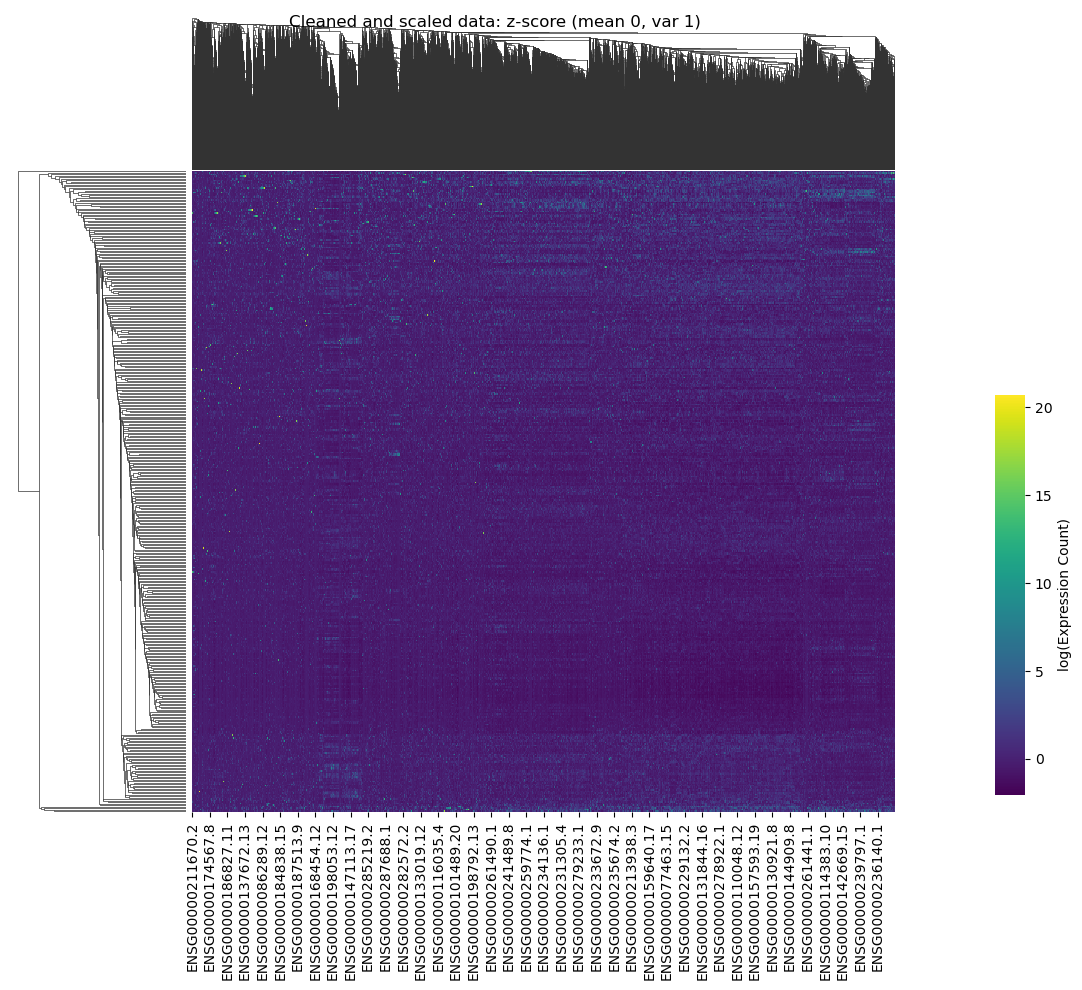

In [95]:
zscore_scaled= sns.clustermap(full_data_zscaled, cmap='viridis',
                              cbar_kws={'label': 'log(Expression Count)'},
                              yticklabels=False, 
                              row_cluster=True)
zscore_scaled.fig.subplots_adjust(right=0.9)
zscore_scaled.ax_cbar.set_position((1, .2, .03, .4))
zscore_scaled.fig.suptitle("Cleaned and scaled data: z-score (mean 0, var 1)")


/opt/anaconda3/envs/andreav/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/andreav/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


AttributeError: module 'matplotlib.pyplot' has no attribute 'save'

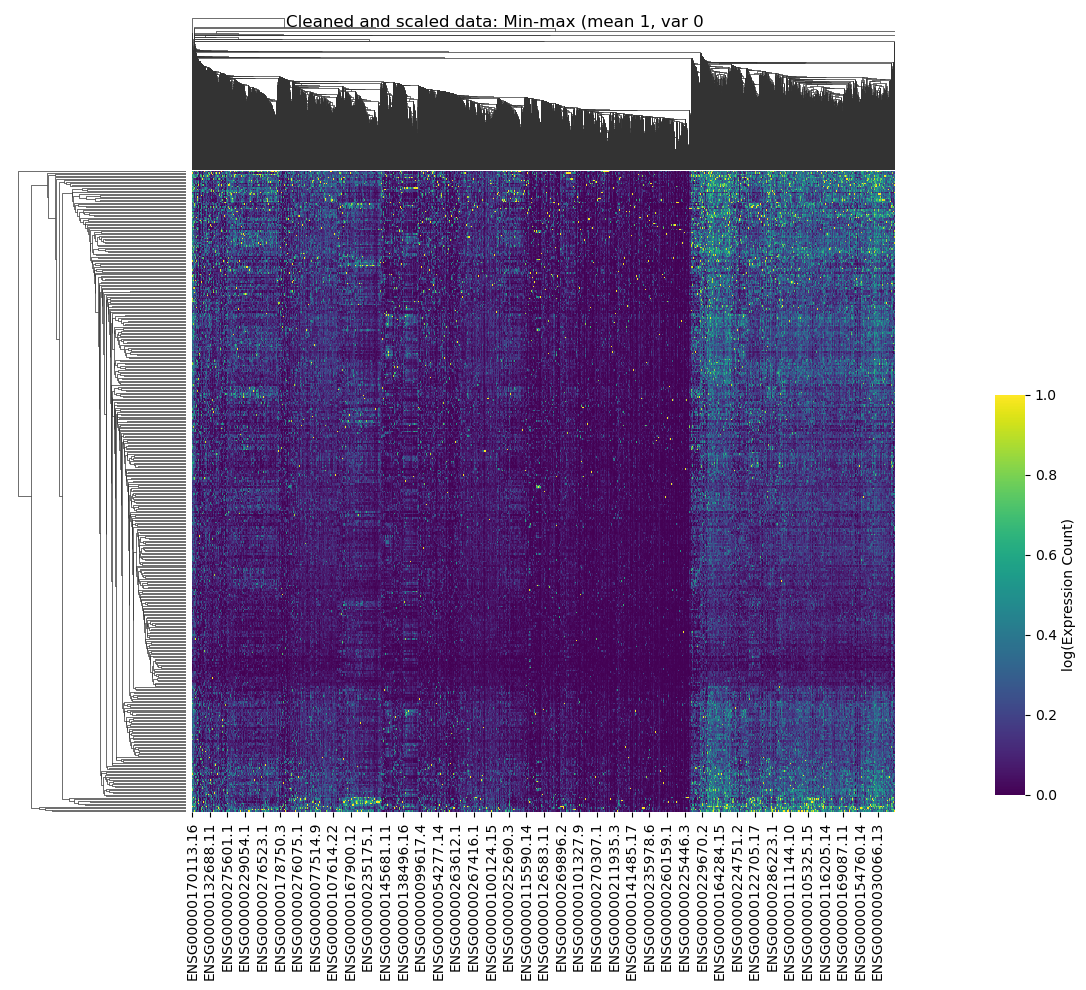

In [96]:
minmax_scaled= sns.clustermap(full_data_minmax, cmap='viridis',
                              cbar_kws={'label': 'log(Expression Count)'},
                              yticklabels=False, 
                              row_cluster=True)
minmax_scaled.fig.subplots_adjust(right=0.9)
minmax_scaled.ax_cbar.set_position((1, .2, .03, .4))
minmax_scaled.fig.suptitle("Cleaned and scaled data: Min-max (mean 1, var 0")

In [98]:
# fig_zscore= zscore_scaled.figure.get_figure()
# fig_zscore.savefig('heatmap_counts_cleaned_zscore.jpeg')

# fig_minmax= minmax_scaled.figure.get_figure()
# fig_minmax.savefig('heatmap_counts_cleaned_minmax.jpeg')

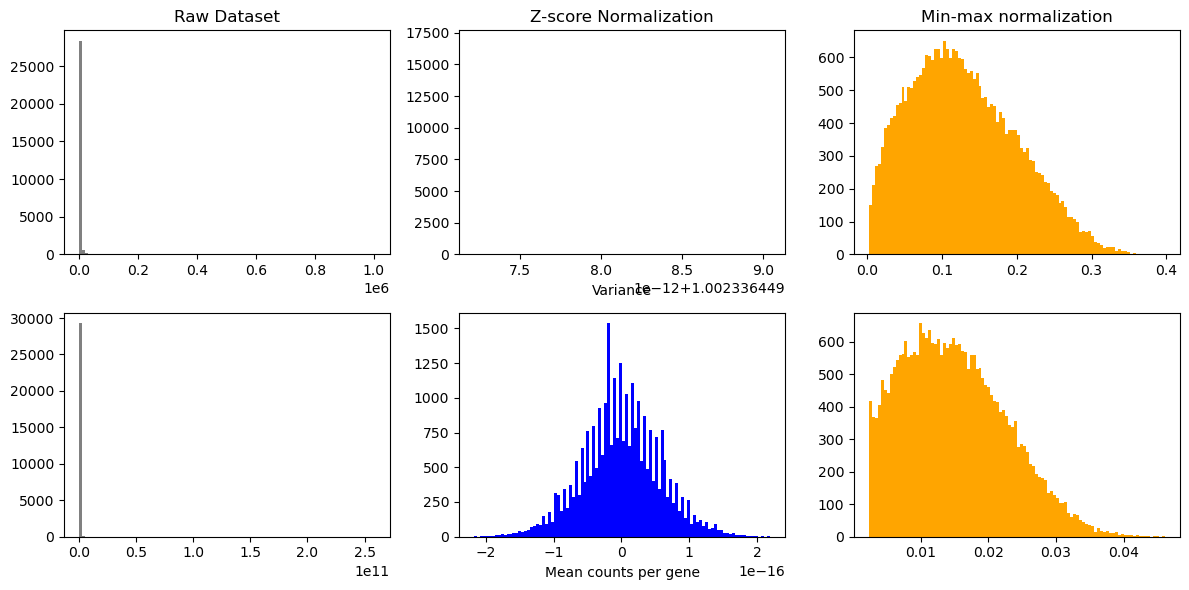

In [101]:
# using the variable axs for multiple Axes
fig_dist, axs = plt.subplots(2, 3, figsize=(12, 6))

axs[0, 0].set_title("Raw Dataset")
axs[0, 0].hist(gene_means, color='gray', bins=100)
axs[1, 0].hist(gene_vars, color='gray', bins=100)
axs[0, 1].set_xlabel("Variance")

axs[0, 1].set_title("Z-score Normalization")
axs[0, 1].hist(full_data_zscaled.var(axis=0), color='blue', bins=100)
axs[1, 1].hist(full_data_zscaled.mean(axis=0), color='blue', bins=100)

axs[0, 2].set_title("Min-max normalization")
axs[0, 2].hist(full_data_minmax.mean(axis=0), color='orange', bins=100)
axs[1, 2].hist(full_data_minmax.var(axis=0), color='orange', bins=100)

axs[1, 1].set_xlabel("Mean counts per gene")
axs[0, 0].set_title("Raw Dataset")

plt.tight_layout()
fig_dist.savefig("Dataset_distributions_graph.jpeg")

In [75]:
#Write csv
# data_merged.to_csv('TCGA_OV_counts_cleaned_raw.csv', index=True)
# full_data_minmax.to_csv('TCGA_OV_counts_cleaned_minmax.csv', index=True)
# full_data_zscaled.to_csv('TCGA_OV_counts_cleaned_zscore.csv', index=True)